# State and server dependent exponential distribution

In [1]:
import ciw
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
class StateServerDependentExponential(ciw.dists.Exponential):
    def __init__(self, rates):
        self.rates = rates

    def sample(self, t=None, ind=None):
        server = ind.server.id_number
        state = ind.simulation.statetracker.state
        rate = self.rates[server][state[0]]

        if hasattr(ind.server, "served_inds"):
            ind.server.served_inds.append(self.simulation.current_time)
        else:
            ind.server.served_inds = [self.simulation.current_time]

        return random.expovariate(rate)


In [4]:
# Use busy time for fair allocation
def busy_time(srv, ind):
    return srv.busy_time

# Define state-server-dependent rates
rates = {}
for server in range(1, 5):
    rates[server] = {state: 1 for state in range(100)}
# When the system reaches 70 customers Server 4 becomes Superman
for state in range(80, 100):
    rates[4][state] = 50

N = ciw.create_network(
    arrival_distributions=[ciw.dists.Exponential(rate=4.5)],
    service_distributions=[StateServerDependentExponential(rates=rates)],
    number_of_servers=[4],
    server_priority_functions=[busy_time],
)
ciw.seed(0)
Q = ciw.Simulation(N, tracker=ciw.trackers.NodePopulation())
Q.simulate_until_max_time(500)

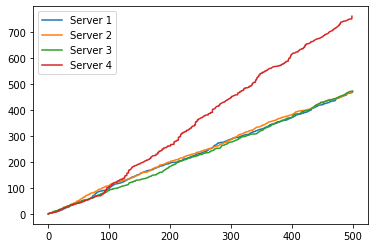

In [5]:
for s in Q.nodes[1].servers:
    plt.plot(
        [0] + [t for t in s.served_inds],
        [0] + [i + 1 for i, t in enumerate(s.served_inds)],
    label=f"Server {s.id_number}") 
    plt.legend() 

## Emergency Department application

In [6]:
import numpy as np
import networkx as nx
import ambulance_game as abg

### Parameters

In [7]:
lambda_1 = 1
lambda_2 = 0.25
mu = 0.5
num_of_servers = 3
threshold = 4
system_capacity = 10
buffer_capacity = 5

runtime = 1000
seed_num = 0

### Markov model

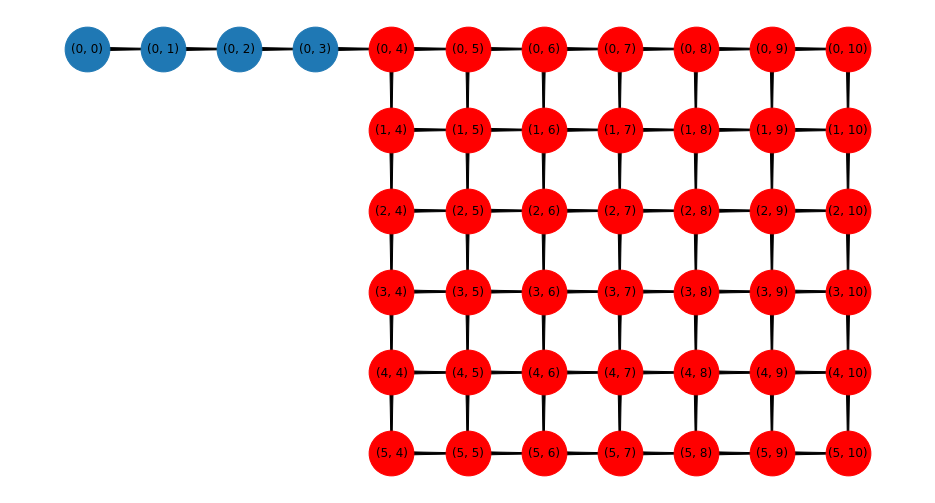

In [175]:
G = abg.markov.visualise_markov_chain(
    num_of_servers=num_of_servers,
    threshold=threshold,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
)

### Normal simualtion VS simulation with server dependent distributions

In [8]:
Q = abg.simulation.simulate_model(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=mu,
    num_of_servers=num_of_servers,
    threshold=threshold,
    seed_num=seed_num,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    runtime=runtime,
    fair_allocation=True,
)

In [9]:
mu = 0.5

In [14]:
# Define the rates to be mu for all server and all states
rates = {}
for k in range(1, num_of_servers + 1):
    rates[k] = {
        (u, v): mu for u in range(20) for v in range(20)
    }

In [15]:
# Add some server specifications
# Server 1: 3*mu when threshold is reached
# Server 2: 2*mu when there is more than 1 individual in the parking
# Server 3: 1.5*mu when total number of people is above 6
for server in rates.keys():
    for (u, v), rate in rates[server].items():
        if server == 1 and v > threshold:
            rates[server][(u, v)] = 3*mu
        if server == 2 and u > 1:
            rates[server][(u, v)] = 2*mu
        if server == 3 and u + v > 6:
            rates[server][(u, v)] = 1.5*mu

In [16]:
Q_server_dep = abg.simulation.simulate_model(
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    mu=rates,
    num_of_servers=num_of_servers,
    threshold=threshold,
    seed_num=seed_num,
    system_capacity=system_capacity,
    buffer_capacity=buffer_capacity,
    runtime=runtime,
    fair_allocation=True,
)

### Waiting time

In [17]:
wait = np.mean([w.waiting_time for w in Q.get_all_records()])
wait_server_dep = np.mean([w.waiting_time for w in Q_server_dep.get_all_records()])

print(f"Mean waiting time (normal simulation): {wait}")
print(f"Mean waiting time (server dependent) : {wait_server_dep}")

Mean waiting time (normal simulation): 0.8911109881942515
Mean waiting time (server dependent) : 0.5334162179072407


### Server busy time

In [18]:
all_times = [s.busy_time for s in Q.nodes[2].servers]
all_times_server_dep = [s.busy_time for s in Q_server_dep.nodes[2].servers]

print("\t\t\t Servers busy times")
print("         - Normal simulation -     - Server dependent simulation -")
for i, (s, s_server_dep) in enumerate(zip(all_times, all_times_server_dep)):
    print(f"Server {i+1}:\t{round(s, 5)},\t\t     {round(s_server_dep, 5)}")

			 Servers busy times
         - Normal simulation -     - Server dependent simulation -
Server 1:	812.65383,		     722.86099
Server 2:	812.53807,		     723.41034
Server 3:	812.53602,		     726.0316
